## Bring in libraries and dataframes and set indexes

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import timedelta
import ETFunctions as et
import MathsUtilities as MUte
import matplotlib.dates as mdates
Lattitude = -43.38
LongitudeTZ = 185
LongitudeML = 360 - 172.28

Path = 'K:\CPDiary\Data\BaxtersMVI'

## Set period to graph data over

In [2]:
Start = datetime.datetime(2017,10,18)
End = datetime.datetime(2018,1,8)

## Bring in data from Low zone and join to existing data

In [3]:
#Get the data that has already been indexed
ExistingLWCZoneData = pd.read_pickle(Path + '\LoggedData\DataFrames\LowWHCZoneAll.pkl')
LowWHCZoneAll = ExistingLWCZoneData.loc[Start:End,:]
#Set up other data frames
LowMetData = LowWHCZoneAll.loc[:,['AirTemp','RelativeHumidity','Wind']].copy()
LowMetData.columns = LowMetData.columns.droplevel([1,2,3])
LowMetData.index = pd.to_datetime(LowMetData.index)
LowWHCZoneTs = LowWHCZoneAll.loc[:,'IR_SurfaceTemp'].copy()
LowWHCZoneTb = LowWHCZoneAll.loc[:,'IR_SensorBodyTemp'].copy()
LowWHCZoneBattery = LowWHCZoneAll.loc[:,'BatteryVoltage']

## Bring in data from Mid zone and join to existing data

In [4]:
#Get the data that has already been indexed
ExistingMWCZoneData = pd.read_pickle(Path + '\LoggedData\DataFrames\MidWHCZoneAll.pkl')
MidWHCZoneAll = ExistingMWCZoneData.loc[Start:End,:]
#Set up other data frames
MidMetData = MidWHCZoneAll.loc[:,['AirTemp','RelativeHumidity','RadnMJ','RadnkW','Rain','Wind']].copy()
MidMetData.index = pd.to_datetime(MidMetData.index)
#Repair radiation data where incorrect coefficients were used
MidMetData.loc[:'2017-10-25 07:20:00','RadnkW'] = MidMetData.loc[:'2017-10-25 07:20:00','RadnkW'].divide(1000).values
MidMetData.loc[:'2017-10-25 07:20:00','RadnMJ'] = MidMetData.loc[:'2017-10-25 07:20:00','RadnkW'].multiply(0.3).values
MidWHCZoneTs = MidWHCZoneAll.loc[:,'IR_SurfaceTemp'].copy()
MidWHCZoneTb = MidWHCZoneAll.loc[:,'IR_SensorBodyTemp'].copy()
MidWHCZoneBattery = MidWHCZoneAll.loc[:,'BatteryVoltage']

## Bring in fresh data from High zone and join to existing data

In [5]:
#Get the data that has already been indexed
ExistingHWCZoneData = pd.read_pickle(Path + '\LoggedData\DataFrames\HighWHCZoneAll.pkl')
HighWHCZoneAll = ExistingHWCZoneData.loc[Start:End,:]
#Set up other data frames
HighMetData = HighWHCZoneAll.loc[:,['AirTemp','RelativeHumidity','Wind']].copy()
HighMetData.columns = HighMetData.columns.droplevel([1,2,3])
HighMetData.index = pd.to_datetime(HighMetData.index)
HighWHCZoneTs = HighWHCZoneAll.loc[:,'IR_SurfaceTemp'].copy()
HighWHCZoneTb = HighWHCZoneAll.loc[:,'IR_SensorBodyTemp'].copy()
HighWHCZoneBattery = HighWHCZoneAll.loc[:,'BatteryVoltage']

## Join stuff together 

In [6]:
#Join everything together and get the formats all right
Zones = ['Low','Mid','High']
Irrigs = ['STD','VRI']
Reps = [1,2,3,4]
colors = ['r','r','g','g','b','b']
fillcolors = ['r','w','g','w','b','w']
lines = ['--','-','--','-','--','-']
ExptIndex = pd.MultiIndex.from_product([Zones, Irrigs, Reps], names = ['Zone', 'Irrig', 'Rep'])
SurfaceTemp = pd.DataFrame(index = LowWHCZoneTs.index, columns = ExptIndex)
SurfaceTemp.update(LowWHCZoneTs)
SurfaceTemp.update(MidWHCZoneTs)
SurfaceTemp.update(HighWHCZoneTs)
SurfaceTemp.index = pd.to_datetime(SurfaceTemp.index)
SurfaceTemp.dropna(inplace=True)
for plot in SurfaceTemp.columns:
    SurfaceTemp.loc[:,plot] = pd.to_numeric(SurfaceTemp.loc[:,plot])
HourlySurfaceTemp = SurfaceTemp.resample('H').mean()
SurfaceTempMeans = HourlySurfaceTemp.groupby(level=['Zone','Irrig'],axis=1).mean()

SensorTemp = pd.DataFrame(index = LowWHCZoneTb.index, columns = ExptIndex)
SensorTemp.update(LowWHCZoneTb)
SensorTemp.update(MidWHCZoneTb)
SensorTemp.update(HighWHCZoneTb)
SensorTemp.index = pd.to_datetime(SensorTemp.index)
SensorTemp.dropna(inplace=True)

## Make data frame with aerodynamic Met variables

In [10]:
MetFiles

Date
2017-10-18 07:30:00    NaN
2017-10-18 07:35:00    NaN
2017-10-18 07:40:00    NaN
2017-10-18 07:45:00    NaN
2017-10-18 07:50:00    NaN
                      ... 
2018-01-07 23:40:00    NaN
2018-01-07 23:45:00    NaN
2018-01-07 23:50:00    NaN
2018-01-07 23:55:00    NaN
2018-01-08 00:00:00    NaN
Name: Ta, Length: 23522, dtype: object

In [13]:
#Join the data from the three logger on each zone
DateTimeList = list(set().union(HighMetData.index,MidMetData.index,LowMetData.index))
list.sort(DateTimeList)
MetIndex = pd.MultiIndex.from_product([Zones,DateTimeList],names=['Zone','Date'])
MetData = pd.DataFrame(index = MetIndex, columns = ['Ta','RH','u','Es','Eo','Ed','Rs','Rex','Rso'])
MetFiles = [LowMetData,MidMetData,HighMetData]
zoneIndex = 0
for zone in Zones:
    zoneMet = MetFiles[zoneIndex]
    MetData.loc[[zone],'Ta'] = zoneMet.reindex(DateTimeList).loc[:,'AirTemp'].values
    MetData.loc[[zone],'RH'] = zoneMet.reindex(DateTimeList).loc[:,'RelativeHumidity'].values/100
    MetData.loc[[zone],'u'] = zoneMet.reindex(DateTimeList).loc[:,'Wind'].values
    MetData.loc[[zone],'Rs'] = MidMetData.reindex(DateTimeList).loc[:,'RadnMJ'].values
    zoneIndex += 1
#Plug T and RH data for Low and High treatments with data from Mid treatment
FullInstrumentationDate = '2017-10-30 13:05:00'
MissingDataDates = MetData.loc['Low',:].loc[:FullInstrumentationDate].index
for mdd in MissingDataDates:
    MetData.loc[('Low',mdd),'Ta'] = MetData.loc[('Mid',mdd),'Ta']
    MetData.loc[('High',mdd),'Ta'] = MetData.loc[('Mid',mdd),'Ta']
    MetData.loc[('Low',mdd),'RH'] = MetData.loc[('Mid',mdd),'RH']
    MetData.loc[('High',mdd),'RH'] = MetData.loc[('Mid',mdd),'RH']
#Derive values from measured met data
MetData.loc[:,'Es'] = [et.saturated_vapor_pressure(MetData.loc[d,'Ta'])/10 for d in MetData.index]
MetData.loc[:,'Eo'] = [MetData.loc[d,'Es'] * MetData.loc[d,'RH'] for d in MetData.index]
MetData.loc[:,'Ed'] = MetData.loc[:,'Es'] - MetData.loc[:,'Eo']
MetData.loc[:,'Rex'] = [et.ExtraterestialRadiation(Lattitude,
                                                       d[1].dayofyear,
                                                       0.083333,
                                                       float(d[1].time().hour) + float(d[1].time().minute)/60.0,
                                                       LongitudeTZ,
                                                       LongitudeML) for d in MetData.index]
MetData.loc[:,'Rso'] = [et.ClearSkyRadiation(Lattitude,
                                                 d[1].dayofyear,
                                                 0.083333,
                                                 float(d[1].time().hour) + float(d[1].time().minute)/60.0,
                                                 LongitudeTZ,
                                                 LongitudeML) for d in MetData.index]

MetData.sort_index(inplace=True)

## Check some status stuff

Text(0, 0.5, 'Battery (volts)')

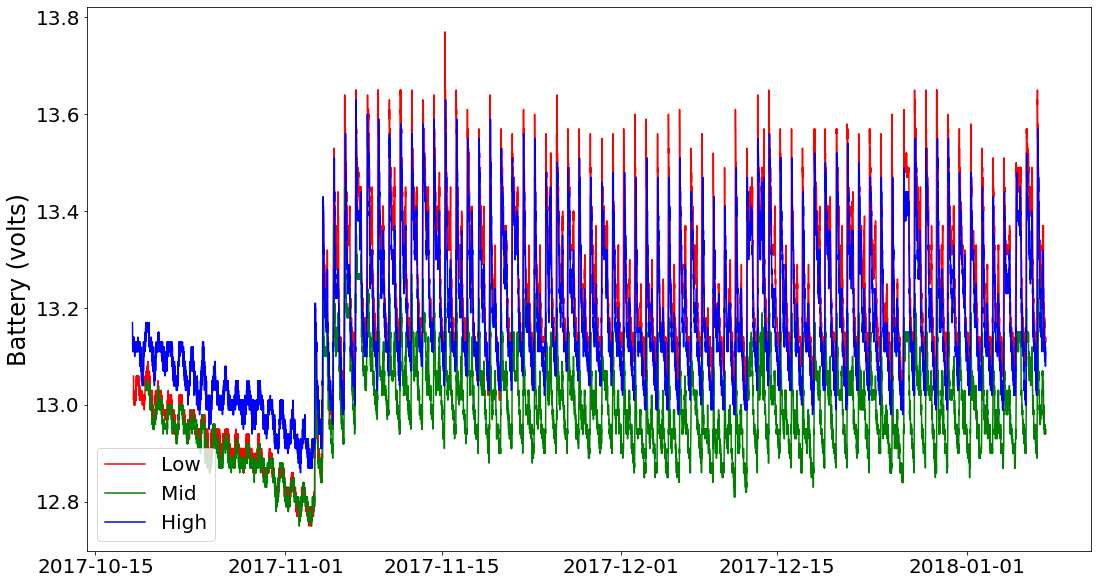

In [14]:
BatteryVoltage = plt.figure(figsize=(18,10))
plt.plot(LowWHCZoneBattery,c='r',label='Low')
plt.plot(MidWHCZoneBattery,c='g',label='Mid')
plt.plot(HighWHCZoneBattery,c='b',label='High')
plt.legend(loc=3,fontsize=20)
plt.tick_params(labelsize=20)
plt.ylabel('Battery (volts)',fontsize = 24)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\A

Text(0, 0.5, 'Sensor temperature (oC)')

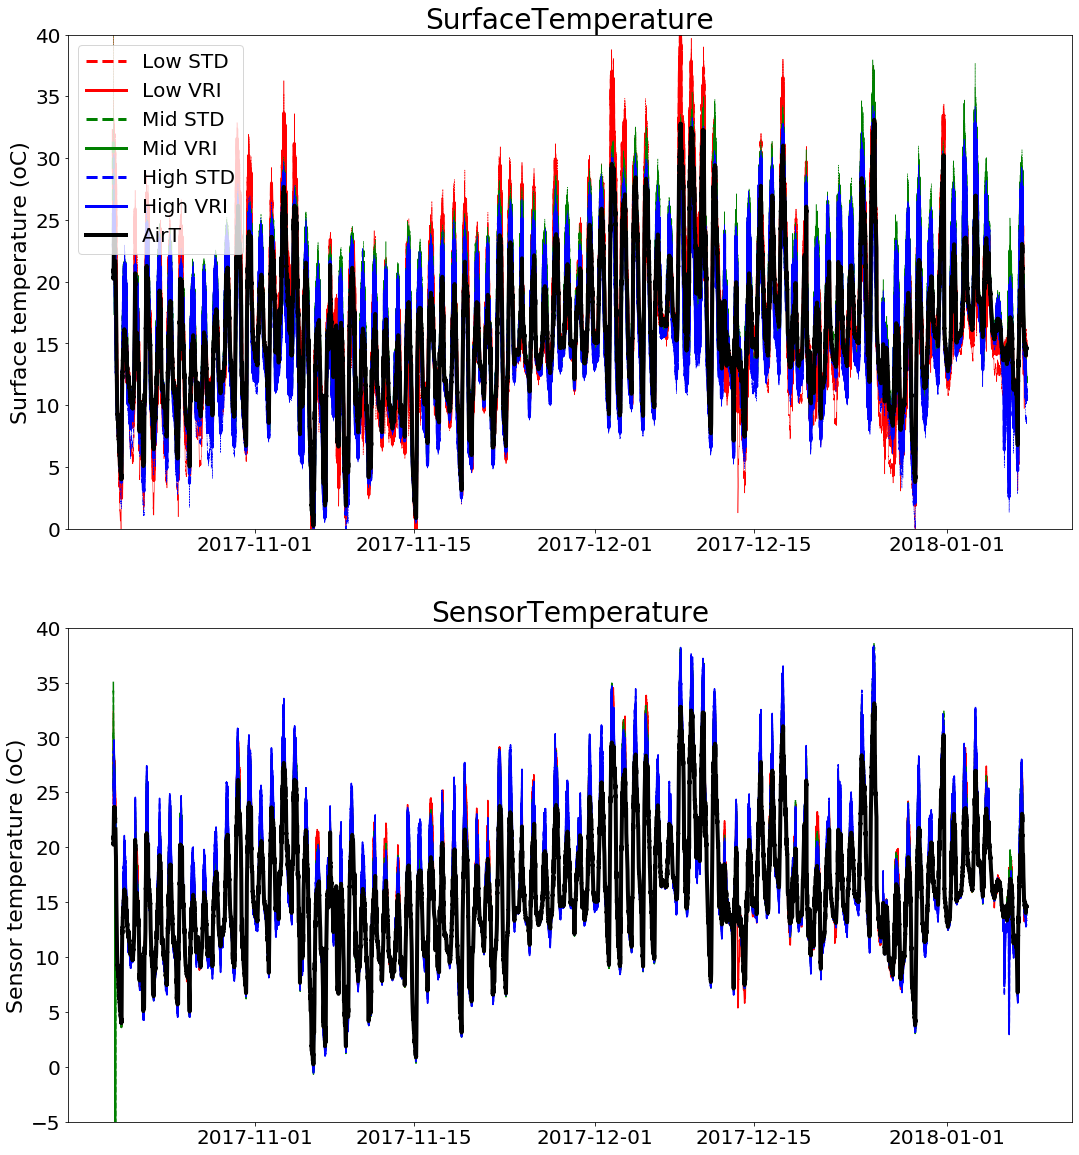

In [15]:
Graph = plt.figure(figsize=(18,20))
pos = 0
Fig = Graph.add_subplot(2,1,1)
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        data = SurfaceTemp.loc[Start:End,(Zone,Irr)]
        plt.plot(data,lines[pos],color = colors[pos],lw=0.5,label = '_nolegend_')
        plt.plot(data.index,data.mean(axis=1),lines[pos],color = colors[pos],lw=3,label = lab)
        pos +=1
plt.plot(MidMetData.loc[Start:End,'AirTemp'],color='k',lw=4,label='AirT')
Fig.legend(loc=2,fontsize=20)
plt.title('SurfaceTemperature',fontsize=28)
plt.tick_params(labelsize=20)
plt.ylabel('Surface temperature (oC)',fontsize = 22)
plt.ylim(0,40)
Graph.add_subplot(2,1,2)
pos = 0
for Zone in Zones:
    for Irr in Irrigs:
        data = SensorTemp.loc[Start:End,(Zone,Irr)]
        plt.plot(data,lines[pos],color = colors[pos])
        pos +=1
plt.plot(MidMetData.loc[Start:End,'AirTemp'],color='k',lw=4)
plt.ylim(-5,40)
plt.tick_params(labelsize=20)
plt.title('SensorTemperature',fontsize=28)
plt.ylabel('Sensor temperature (oC)',fontsize = 22)

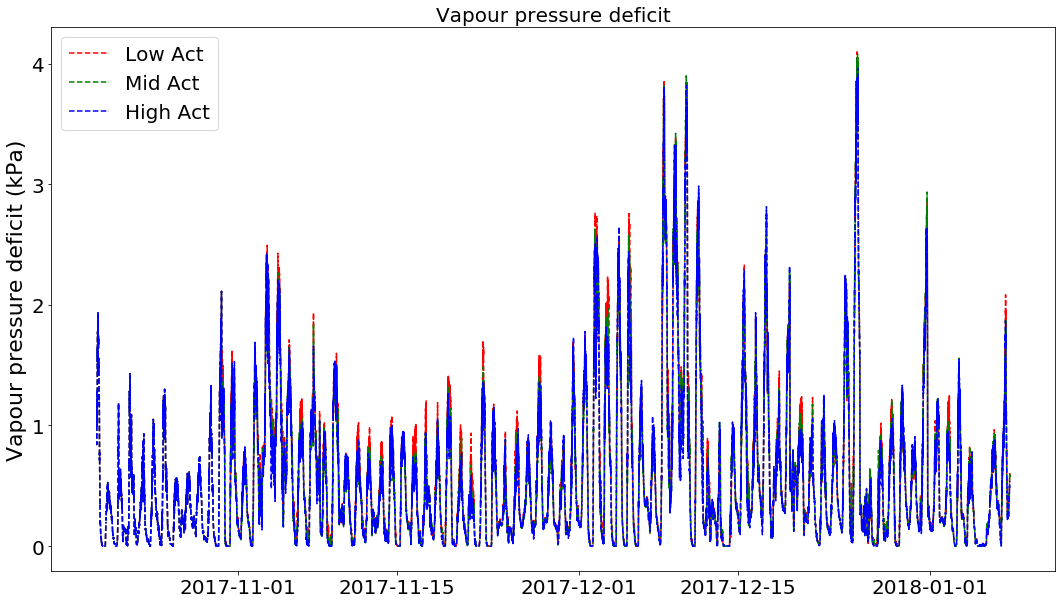

In [16]:
VPGraph = plt.figure(figsize=(18,10))
colpos = 0
for zone in Zones:
    plt.plot(MetData.loc[zone,'Ed'].loc[Start:End],'--',color = colors[colpos], label = zone + ' Act')
    colpos+=2
plt.legend(loc=2,fontsize=20)
plt.title('Vapour pressure deficit',fontsize=20)
plt.ylabel('Vapour pressure deficit (kPa)',fontsize=22)
plt.tick_params(labelsize=20)

(0, 10)

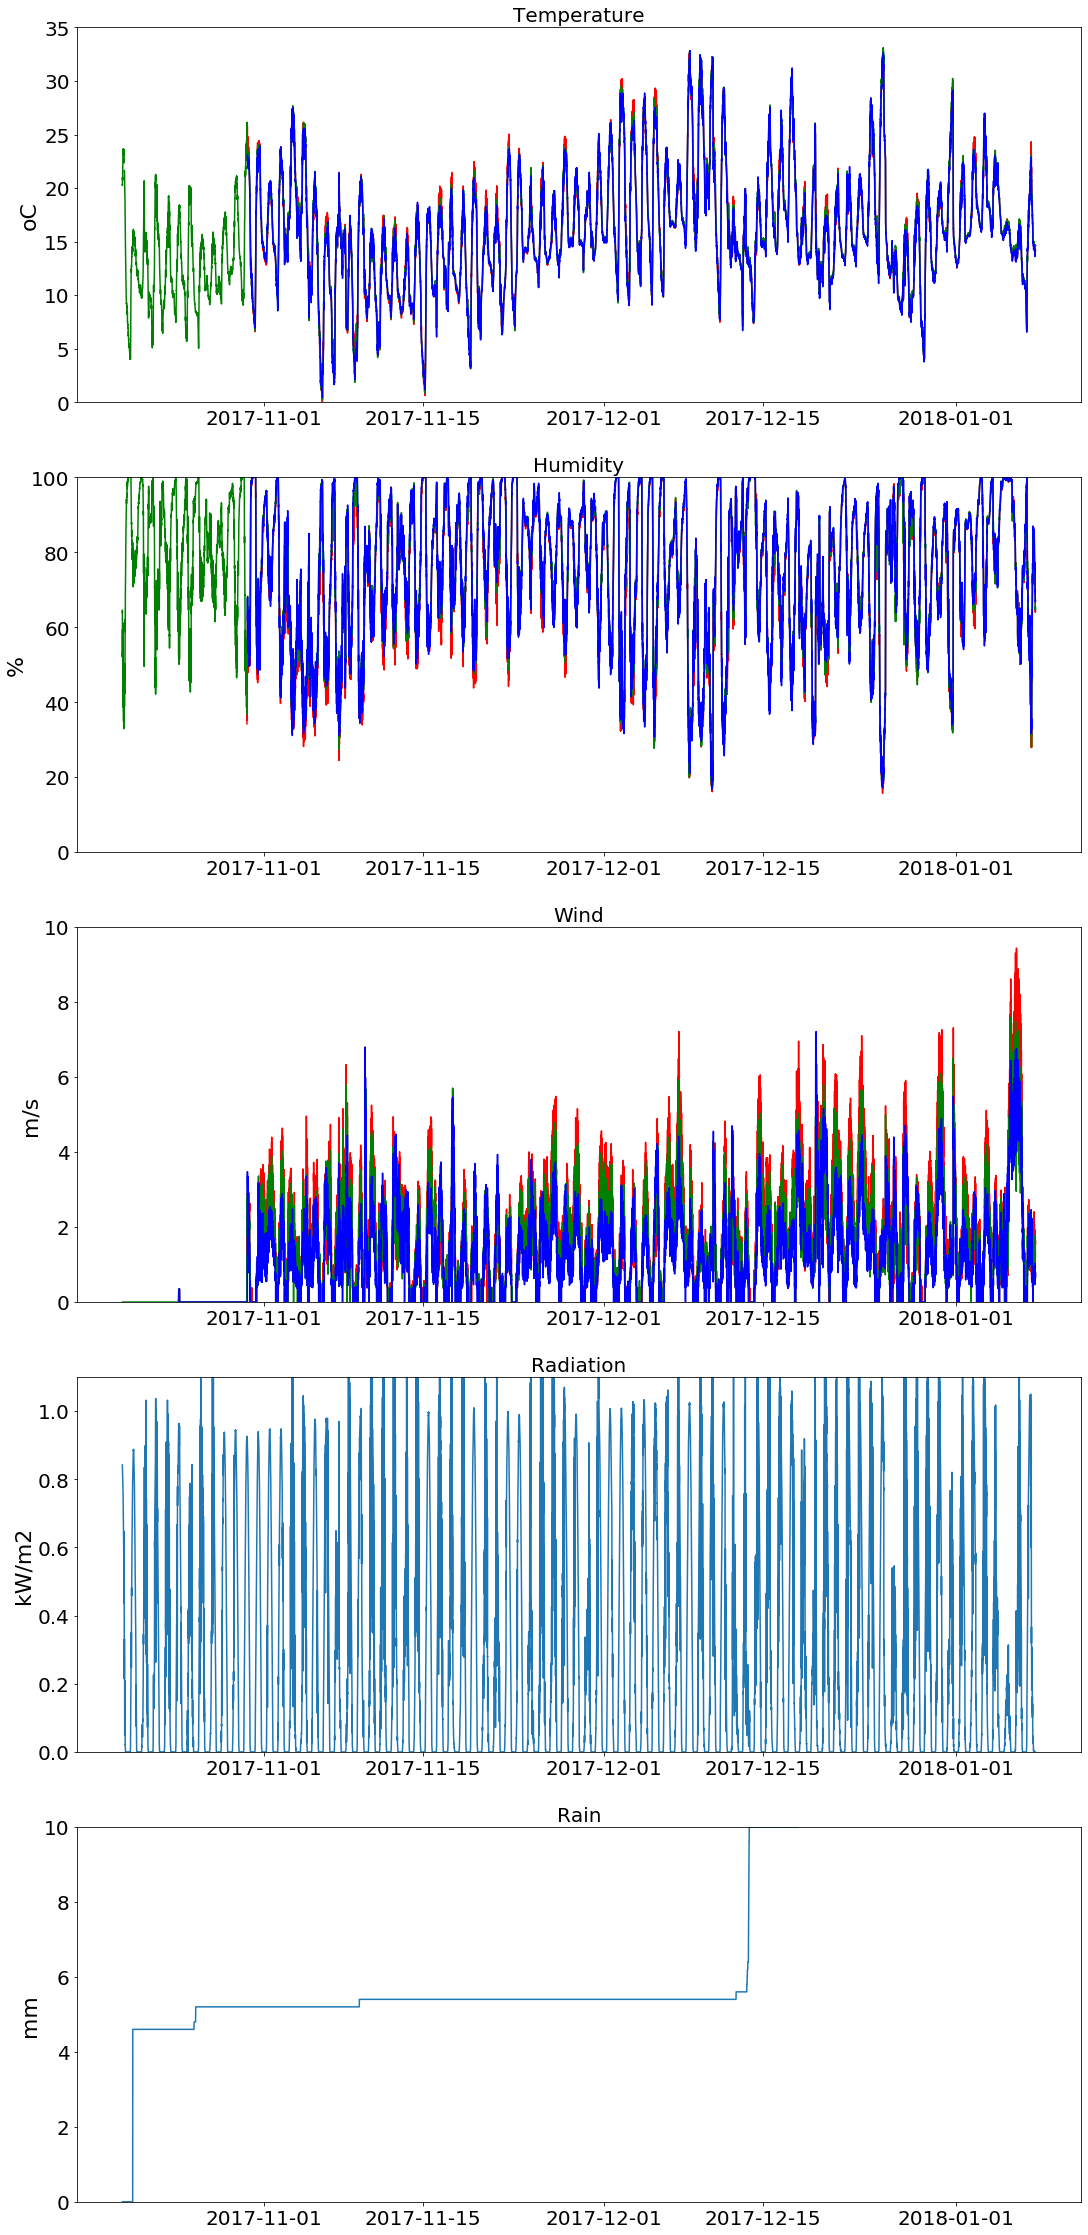

In [17]:
MetGraph = plt.figure(figsize=(18,40))
TempPannel = MetGraph.add_subplot(5,1,1)
plt.plot(LowMetData.loc[Start:End,'AirTemp'],color = 'r')
plt.plot(MidMetData.loc[Start:End,'AirTemp'],color = 'g')
plt.plot(HighMetData.loc[Start:End,'AirTemp'],color = 'b')
plt.title('Temperature',fontsize=20)
plt.ylabel('oC',fontsize=22)
plt.tick_params(labelsize=20)
plt.ylim(0,35)
HumidityPannel = MetGraph.add_subplot(5,1,2)
plt.plot(LowMetData.loc[Start:End,'RelativeHumidity'],color = 'r')
plt.plot(MidMetData.loc[Start:End,'RelativeHumidity'],color = 'g')
plt.plot(HighMetData.loc[Start:End,'RelativeHumidity'],color = 'b')
plt.title('Humidity',fontsize=20)
plt.ylabel('%',fontsize=22)
plt.tick_params(labelsize=20)
plt.ylim(0,100)
WindPannel = MetGraph.add_subplot(5,1,3)
plt.plot(LowMetData.loc[Start:End,'Wind'],color = 'r')
plt.plot(MidMetData.loc[Start:End,'Wind'],color = 'g')
plt.plot(HighMetData.loc[Start:End,'Wind'],color = 'b')
plt.title('Wind',fontsize=20)
plt.ylabel('m/s',fontsize=22)
plt.tick_params(labelsize=20)
plt.ylim(0,10)
RadnPannel = MetGraph.add_subplot(5,1,4)
plt.plot(MidMetData.loc[Start:End,'RadnkW'])
plt.title('Radiation',fontsize=20)
plt.ylabel('kW/m2',fontsize=22)
plt.tick_params(labelsize=20)
plt.ylim(0,1.100)
RainfallPannel = MetGraph.add_subplot(5,1,5)
plt.plot(MidMetData.loc[Start:End,'Rain'].cumsum())
plt.title('Rain',fontsize=20)
plt.ylabel('mm',fontsize=22)
plt.tick_params(labelsize=20)
plt.ylim(0,10)

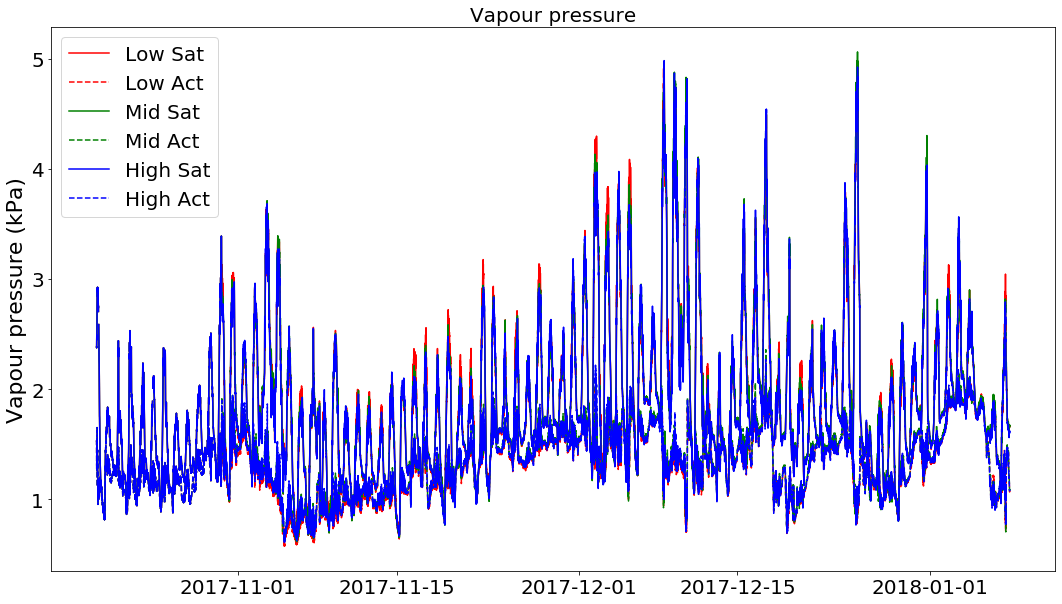

In [18]:
VPGraph = plt.figure(figsize=(18,10))
colpos = 0
for zone in Zones:
    plt.plot(MetData.loc[zone,'Es'].loc[Start:End],color = colors[colpos], label = zone + ' Sat')
    plt.plot(MetData.loc[zone,'Eo'].loc[Start:End],'--',color = colors[colpos], label = zone + ' Act')
    colpos+=2
plt.legend(loc=2,fontsize=20)
plt.title('Vapour pressure',fontsize=20)
plt.ylabel('Vapour pressure (kPa)',fontsize=22)
plt.tick_params(labelsize=20)

In [19]:
Daylight = (MetData.loc['Mid','Rs'] > 0.01) & (MetData.loc['Mid','Rs'].index > '2017-10-15') & (MetData.loc['Mid','Ed'] > 0.1)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


Text(0, 0.5, 'Surface temperature (oC)')

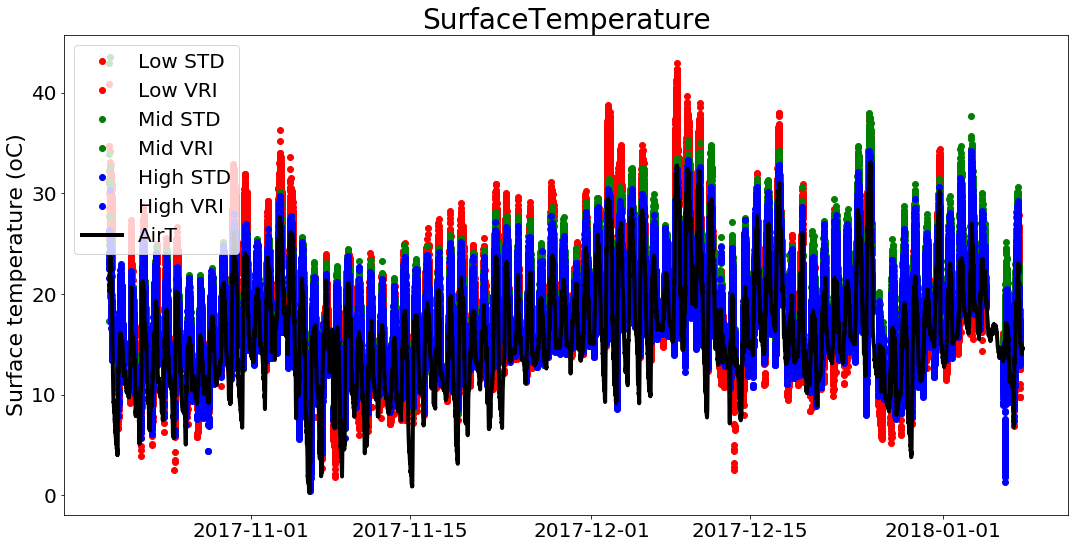

In [20]:
Graph = plt.figure(figsize=(18,30))
pos = 0
Fig = Graph.add_subplot(3,1,1)
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        data = SurfaceTemp.loc[Daylight,(Zone,Irr)].loc[Start:End]
        plt.plot(data,'o',color = colors[pos],lw=0.5,label = '_nolegend_')
        plt.plot(data.index,data.mean(axis=1),'o',color = colors[pos],lw=3,label = lab)
        pos +=1
plt.plot(MidMetData.loc[Start:End,'AirTemp'],color='k',lw=4,label='AirT')
Fig.legend(loc=2,fontsize=20)
plt.title('SurfaceTemperature',fontsize=28)
plt.tick_params(labelsize=20)
plt.ylabel('Surface temperature (oC)',fontsize = 22)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


Text(0, 0.5, 'Surface temperature (oC)')

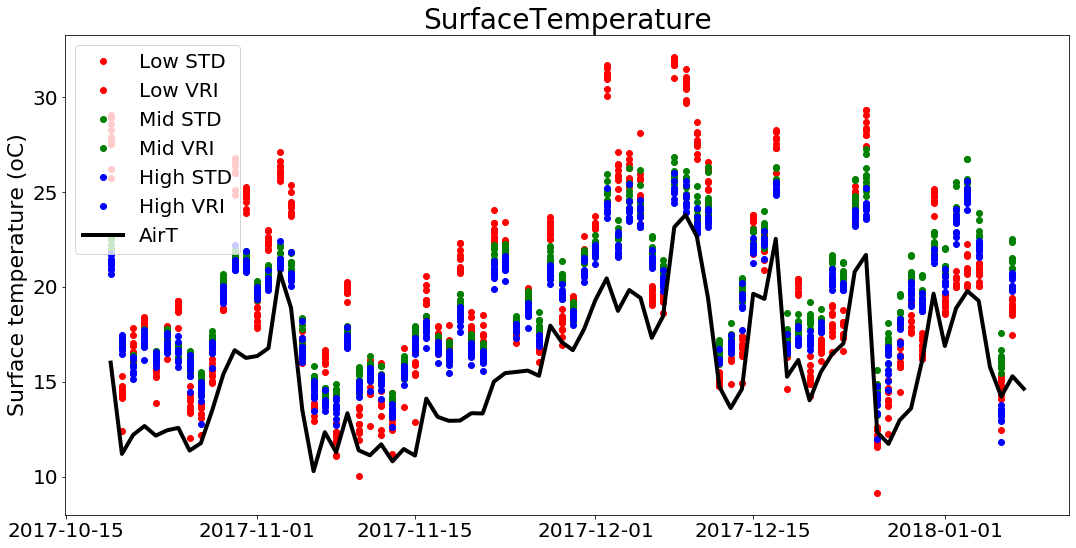

In [21]:
Graph = plt.figure(figsize=(18,30))
pos = 0
Fig = Graph.add_subplot(3,1,1)
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        data = SurfaceTemp.loc[Daylight,(Zone,Irr)].loc[Start:End].resample('d').mean()
        plt.plot(data,'o',color = colors[pos],lw=0.5,label = '_nolegend_')
        plt.plot(data.index,data.mean(axis=1),'o',color = colors[pos],lw=3,label = lab)
        pos +=1
plt.plot(MidMetData.loc[Start:End,'AirTemp'].resample('d').mean(),color='k',lw=4,label='AirT')
Fig.legend(loc=2,fontsize=20)
plt.title('SurfaceTemperature',fontsize=28)
plt.tick_params(labelsize=20)
plt.ylabel('Surface temperature (oC)',fontsize = 22)

## Bring in the albedo and cover data

(0, 1.1)

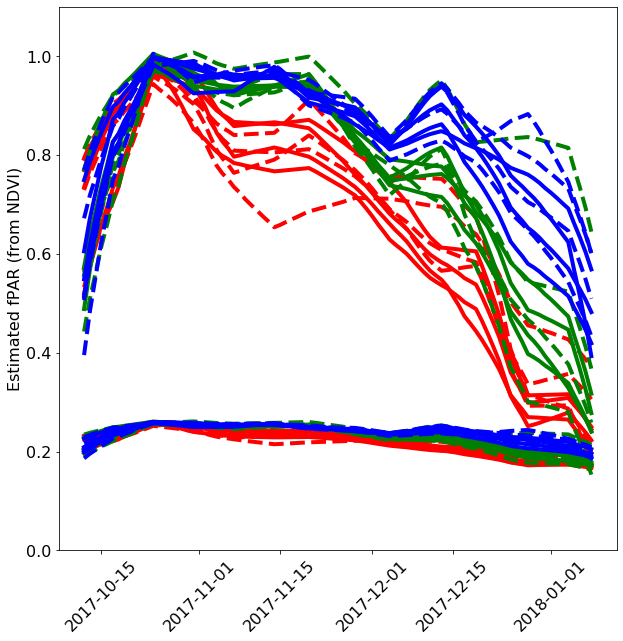

In [22]:
Albedo = pd.read_pickle('Albedo.pkl')
fPAR = pd.read_pickle('fPAR.pkl')

NDVIGraph = plt.figure(figsize=(10,10))
pos = 0
for Zone in Zones:
    for Irrig in Irrigs:
        plt.plot(Albedo.index,Albedo.loc[:,(Zone,Irrig)],lines[pos],color=colors[pos],label=Zone+Irrig,lw=4)
        plt.plot(fPAR.index,fPAR.loc[:,(Zone,Irrig)],lines[pos],color=colors[pos],label='_nolegend_',lw=4)
        pos+=1
plt.ylabel('Estimated fPAR (from NDVI)',fontsize=16)
plt.xticks(rotation=45)
plt.tick_params(labelsize=16)
plt.ylim(0,1.1)
#plt.legend(loc=2,fontsize=16)

## Calculate net radiation for each plot

In [23]:
#Bring in the calculations already made
ExistingRadnCalcs = pd.read_pickle(Path + '\\LoggedData\\DataFrames\\NetRadData.pkl')
LastCalcTo = ExistingRadnCalcs.index.max()
EBDates = list(set([DateTimeList[x].date() for x in range(len(DateTimeList))]))
list.sort(EBDates)
RadnCols = pd.MultiIndex.from_product([Zones,Irrigs,Reps],names=['Zone','Irrig','Rep'])
NetRadData = pd.DataFrame(index = DateTimeList, columns = RadnCols)
NetRadData.update(ExistingRadnCalcs)
#Calcualate parameters for the fresh data
for plot in NetRadData.columns:
    NetRadData.loc[LastCalcTo:,plot] = [et.NetRadiation(MetData.loc[(plot[0],d),'Rs'],
                                                    MetData.loc[(plot[0],d),'Ta'],
                                                    MetData.loc[(plot[0],d),'Eo'],
                                                    Lattitude,
                                                    d.dayofyear,
                                                    0.083333,
                                                    float(d.time().hour) + float(d.time().minute)/60.0,
                                                    LongitudeTZ,
                                                    LongitudeML,
                                                    Albedo.loc[EBDates,:].loc[d.date(),plot]) for d in NetRadData.loc[LastCalcTo:,:].index]
NetRadData.to_pickle(Path + '\\LoggedData\\DataFrames\\NetRadData.pkl')

## Have a look at sub daily radiation

Text(0, 0.5, 'Solar Radiation (MJ/m2/5min)')

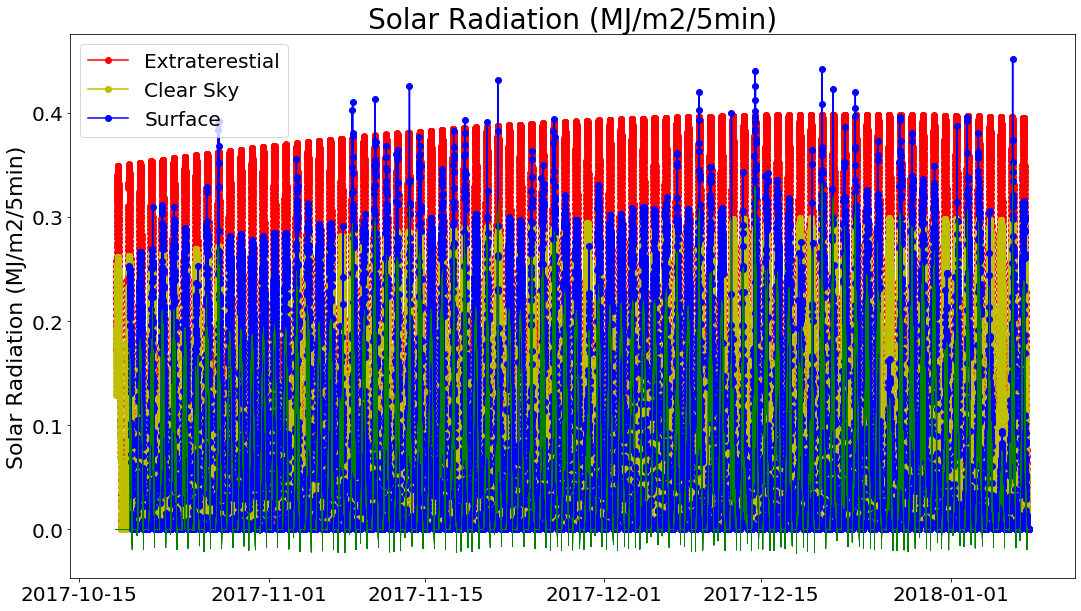

In [24]:
figure = plt.figure(figsize=(18,10))
plt.plot(MetData.loc['Mid','Rex'].loc[Start:End],'-o',color='r',label='Extraterestial')
plt.plot(MetData.loc['Mid','Rso'].loc[Start:End],'-o',color='y',label='Clear Sky')
plt.plot(MetData.loc['Mid','Rs'].loc[Start:End],'-o',color='b',label='Surface')
for plot in NetRadData.columns:
    plt.plot(NetRadData.loc[Start:End,plot],color = 'g',lw=0.5,label = '_nolegend_')
plt.legend(loc=2,fontsize=20)
plt.title('Solar Radiation (MJ/m2/5min)',fontsize=28)
plt.tick_params(labelsize=20)
plt.ylabel('Solar Radiation (MJ/m2/5min)',fontsize = 22)

## Calculate daily values for input data

In [25]:
## Note.  We found an error in the calculations for estGDay coefficients when 
## revising the companion paper
## As the paper describing this work had already been referreed we have not 
## changed these and note it only makes a samll difference  
## The correct coefficients are commented below
def estGDay(SoilRadn, AirTemp):
    Const = -0.7091  ## -0.6139
    SoilRadEff = np.multiply(SoilRadn.values,0.2149) ##0.0801
    AirTempEff = np.multiply(AirTemp.values,0.0739) ##0.0659
    return Const + SoilRadEff  + AirTempEff 

#Calculate Ts for each plot
Ts = SurfaceTemp.loc[Daylight,:].dropna().resample('d').mean()
#Calculate Rn for each plot
Rn = NetRadData.resample('d').sum().loc[Ts.index]
#calculate Rs for the experiment
Rs = MetData.loc['Mid','Rs'].resample('d').sum().loc[Ts.index]
#Calculate Ta for each zone
Ta = pd.DataFrame(index = Rn.index, columns = Zones)
for zone in Ta.columns:
    Ta.loc[:,zone] = pd.to_numeric(MetData.loc[zone,'Ta'].loc[Daylight]).resample('d').mean()
#Calculate Ed for each zone
Ed = pd.DataFrame(index = Rn.index, columns = Zones)
for zone in Ta.columns:
    Ed.loc[:,zone] = pd.to_numeric(MetData.loc[zone,'Ed'].loc[Daylight]).resample('d').mean()
#Calculate G for each plot
G = pd.DataFrame(index=Rn.index, columns=Rn.columns)
for plot in G.columns:
    G.loc[:,plot] = estGDay(Rs * (1-fPAR.loc[G.index,plot]), Ta.loc[:,plot[0]])
RnLessG = Rn - G
#Calculate u for each zone
u = pd.DataFrame(index = Rn.index, columns = Zones)
for zone in u.columns:
    u.loc[:,zone] = pd.to_numeric(MetData.loc[zone,'u'].loc[Daylight]).resample('d').mean()

In [26]:
#Calculate Eo for each zone
Eo = pd.DataFrame(index = Rn.index, columns = Zones)
for zone in Eo.columns:
    Eo.loc[:,zone] = pd.to_numeric(MetData.loc[zone,'Eo'].loc[Daylight]).resample('d').mean()

## Check daily radiation data

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\A

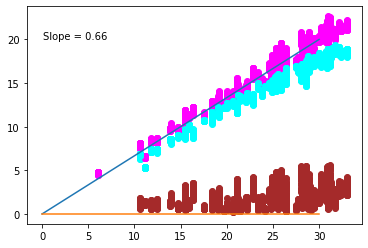

In [27]:
pos=0
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        plt.plot(Rs,Rn.loc[:,(Zone,Irr)],'o',color = 'magenta',lw=0.5,label = 'Net Rad (Rn)')
        plt.plot(Rs,G.loc[:,(Zone,Irr)],'o',color = 'brown',lw=0.5,label = 'Ground Heat (G)')
        plt.plot(Rs,RnLessG.loc[:,(Zone,Irr)],'o',color = 'cyan',lw=0.5,label = 'Rn - G')
        pos +=1
plt.plot([0,30],[0,20],'-')
plt.text(0.1,20,'Slope = 0.66')
plt.plot([0,30],[0,0],'-')

## Calculate temperature variables from measured data

In [28]:
#Calculate aerodynamic temperature
To = pd.DataFrame(index = Rn.index,columns=Rn.columns)
for plot in To.columns:
    To.loc[:,plot] = Ts.loc[:,plot] + Ed.loc[:,plot[0]]
    
#Calculate temperature difference
Td = pd.DataFrame(index = Rn.index,columns=Rn.columns)
for plot in Td.columns:
    Td.loc[:,plot] = To.loc[:,plot] - Ta.loc[:,plot[0]]
#Calculate alpha
def AlphaCoeff(Td,fPAR):
    CoverFact = 0.1+1.6*fPAR
    if CoverFact > 1.0:
        CoverFact = 1.0
    return 1.3 * np.exp(Td*-0.13) * CoverFact
    #return 1/(0.68 + 0.18*Td ) * CoverFact
    #return np.exp(0.2663)  * np.exp(Td*-0.1270) * CoverFact
    #return np.exp(0.34)  * np.exp(Td*-0.14) * CoverFact
    
Alpha = pd.DataFrame(index = Rn.index,columns=Rn.columns)
for plot in Alpha.columns:
    Alpha.loc[:,plot] = [AlphaCoeff(Td.loc[x,plot],
                                   fPAR.loc[x,plot]) for x in Alpha.index]

#Estimate Water Use by surfaces
E = pd.DataFrame(index = Rn.index,columns=Rn.columns)
for plot in E.columns:
    E.loc[:,plot] = [et.Priestly_TaylorEO(RnLessG.loc[x,plot],
                                         Ta.loc[x,plot[0]],
                                         Alpha.loc[x,plot],
                                         'net') for x in E.index]
#Calculate alpha
def Alpha_TsCoeff(Td,fPAR):
    CoverFact = 0.1+1.6*fPAR
    if CoverFact > 1.0:
        CoverFact = 1.0
    return 1/(0.83 + 0.17*Td ) * CoverFact

Alpha_Ts = pd.DataFrame(index = Rn.index,columns=Rn.columns)
for plot in Alpha.columns:
    Alpha_Ts.loc[:,plot] = [Alpha_TsCoeff(Td.loc[x,plot],
                                   fPAR.loc[x,plot]) for x in Alpha.index]

E_Ts = pd.DataFrame(index = Rn.index,columns=Rn.columns)
for plot in E.columns:
    E_Ts.loc[:,plot] = [et.Priestly_TaylorEO(RnLessG.loc[x,plot],
                                         Ta.loc[x,plot[0]],
                                         Alpha_Ts.loc[x,plot],
                                         'net') for x in E.index]

E_Ts_R = pd.DataFrame(index = Rn.index,columns=Rn.columns)
for plot in E.columns:
    E_Ts_R.loc[:,plot] = [et.Priestly_TaylorEO(Rn.loc[x,plot],
                                         Ta.loc[x,plot[0]],
                                         Alpha_Ts.loc[x,plot],
                                         'net') for x in E.index]


In [29]:
PET = pd.DataFrame(index = Rn.index,columns=Rn.columns)
for plot in E.columns:
    PET.loc[:,plot] = [et.PenmanEO(Rn.loc[x,plot],
                        Ta.loc[x,plot[0]],
                        u.loc[x,plot[0]],
                        Eo.loc[x,plot[0]],
                        'net') for x in E.index]

In [48]:
DailyData = pd.DataFrame(Ts.unstack())
DailyData.columns = ['Ts']
DailyVariables = ['Rn','G','To','Td','Alpha','E','Albedo','fPAR','E_Ts','E_Ts_R']
for Var in DailyVariables:
    print(Var)
    VarFrame = globals()[Var]
    Varunstk = pd.DataFrame(VarFrame.unstack())
    Varunstk.columns = [Var]
    DailyData = DailyData.join(Varunstk)

Rn


ValueError: cannot join with no overlapping index names

In [32]:
DailyData.loc[:,'Rs'] = np.nan
DailyData.loc[:,'Ed'] = np.nan
DailyData.loc[:,'Ta'] = np.nan
DailyData.loc[:,'u'] = np.nan
for Z in Zones:
    for I in Irrigs:
        for R in Reps:
            DailyData.loc[(Z,I,R),'Rs'] = Rs.values
            DailyData.loc[(Z,I,R),'Ed'] = Ed.loc[:,Z].values
            DailyData.loc[(Z,I,R),'Ta'] = Ta.loc[:,Z].values
            DailyData.loc[(Z,I,R),'u'] = u.loc[:,Z].values

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2854: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
C:\Anaconda\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [ ]:
DailyData.to_excel('K:\CPDiary\Data\BaxtersMVI\TempNRadRawData12.xlsx',merge_cells=False,sheet_name='RawData')

## Take a look at some of the daily data

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\A

Text(0, 0.5, 'Evaporation')

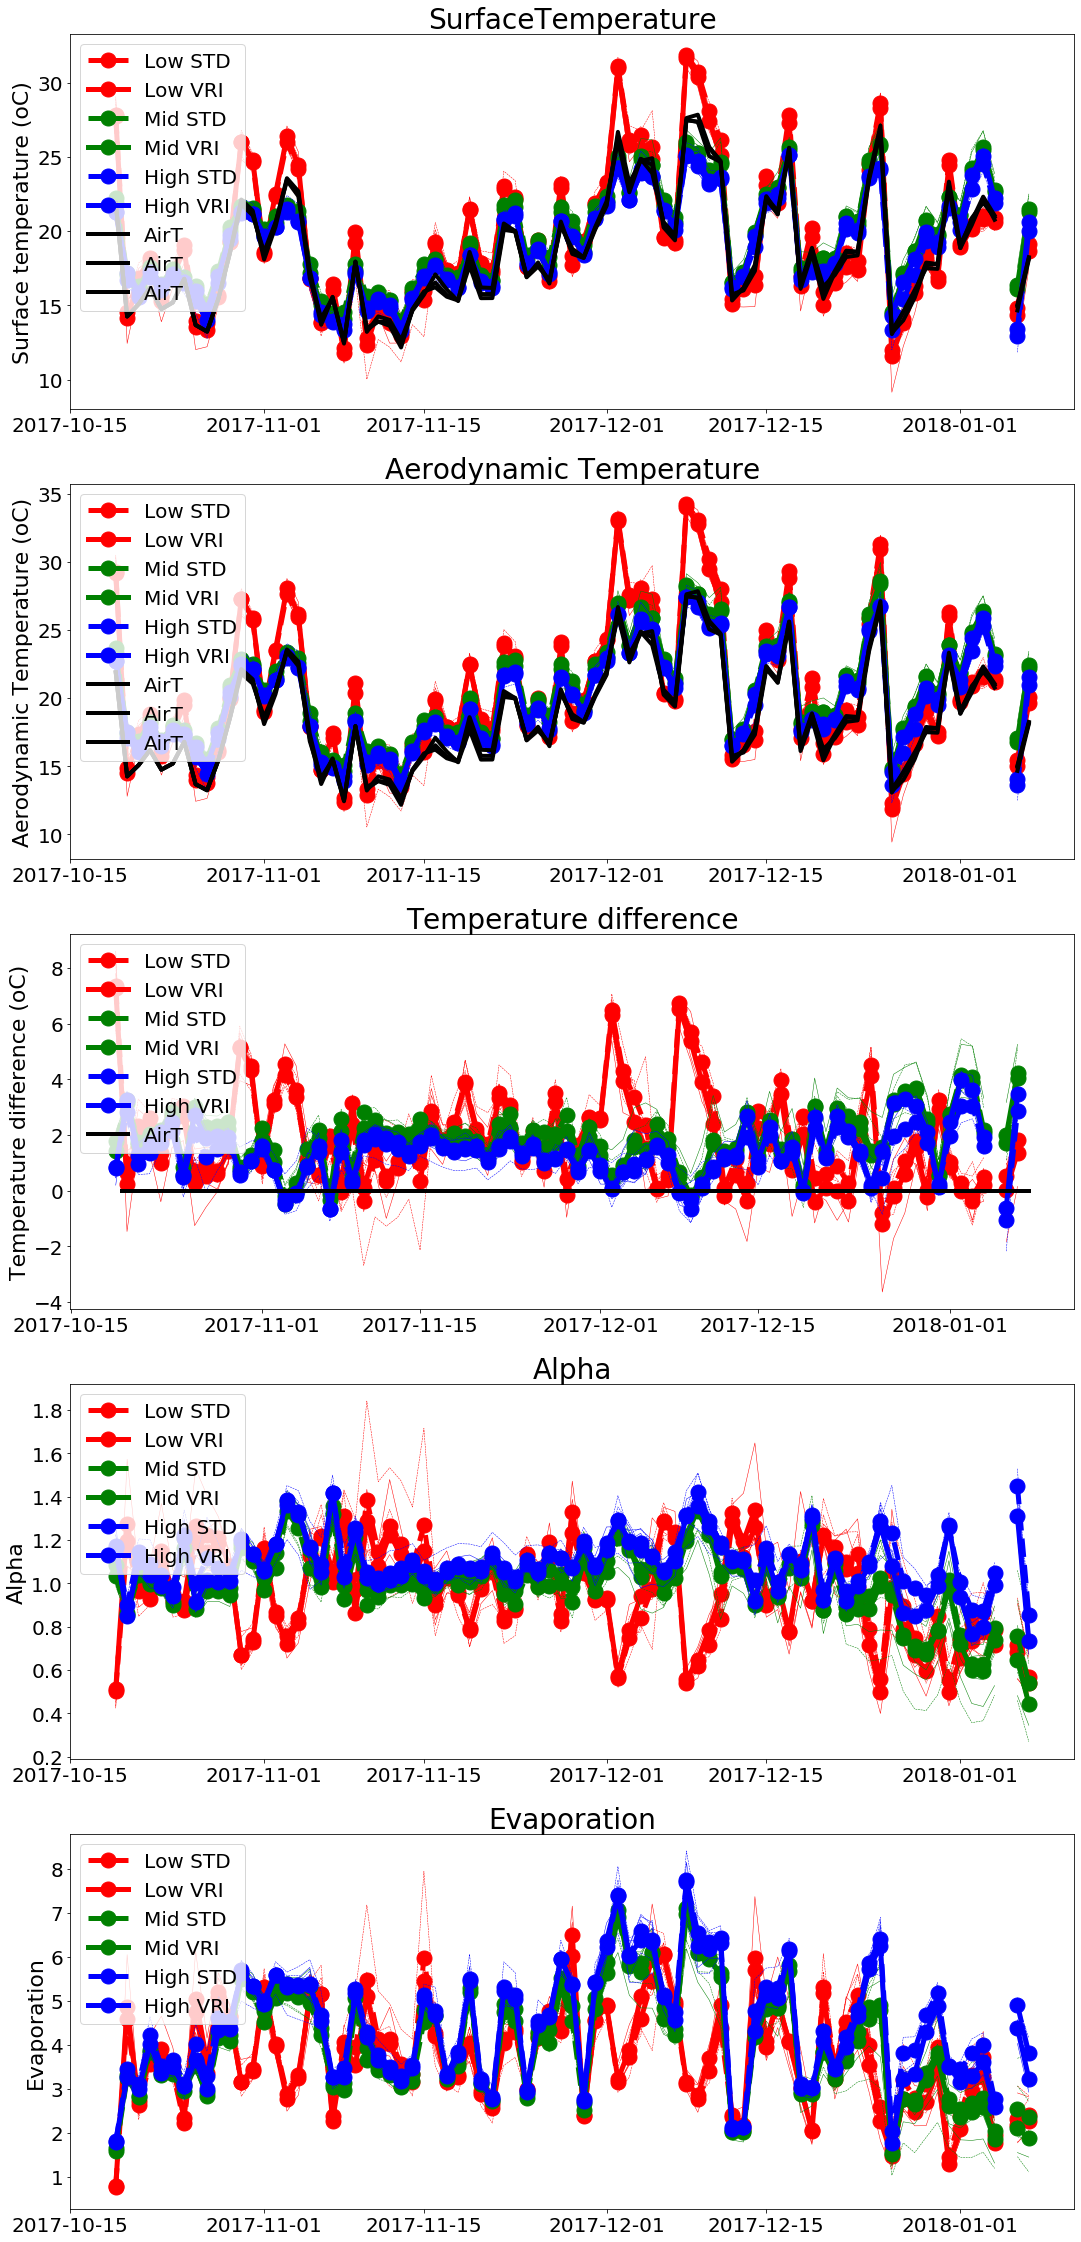

In [33]:
#Start = Today - timedelta(days=12)
Graph = plt.figure(figsize=(18,40))
pos = 0
Fig = Graph.add_subplot(5,1,1)
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        data = Ts.loc[:,(Zone,Irr)].loc[Start:End]
        plt.plot(data,lines[pos],color = colors[pos],lw=0.5,label = '_nolegend_')
        plt.plot(data.index,data.mean(axis=1),lines[pos]+'o',color = colors[pos],lw=5,label = lab,ms=15)
        pos +=1
plt.plot(Ta.loc[Start:End],color='k',lw=4,label='AirT')
Fig.legend(loc = 2, fontsize=20)
plt.title('SurfaceTemperature',fontsize=28)
plt.tick_params(labelsize=20)
plt.ylabel('Surface temperature (oC)',fontsize = 22)
pos=0
Fig = Graph.add_subplot(5,1,2)
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        data = To.loc[:,(Zone,Irr)].loc[Start:End]
        plt.plot(data,lines[pos],color = colors[pos],lw=0.5,label = '_nolegend_')
        plt.plot(data.index,data.mean(axis=1),lines[pos]+'o',color = colors[pos],lw=5,label = lab,ms=15)
        pos +=1
plt.plot(Ta.loc[Start:End],color='k',lw=4,label='AirT')
Fig.legend(loc = 2, fontsize=20)
plt.title('Aerodynamic Temperature',fontsize=28)
plt.tick_params(labelsize=20)
plt.ylabel('Aerodynamic Temperature (oC)',fontsize = 22)
pos=0
Fig = Graph.add_subplot(5,1,3)
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        data = Td.loc[:,(Zone,Irr)].loc[Start:End]
        plt.plot(data,lines[pos],color = colors[pos],lw=0.5,label = '_nolegend_')
        plt.plot(data.index,data.mean(axis=1),lines[pos]+'o',color = colors[pos],lw=5,label = lab,ms=15)
        pos +=1
plt.plot([MidMetData.loc[Start:End,'AirTemp'].index.min(),MidMetData.index.max().date()],[0,0],color='k',lw=4,label='AirT')
Fig.legend(loc = 2, fontsize=20)
plt.title('Temperature difference',fontsize=28)
plt.tick_params(labelsize=20)
plt.ylabel('Temperature difference (oC)',fontsize = 22)
pos=0
Fig = Graph.add_subplot(5,1,4)
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        data = Alpha.loc[:,(Zone,Irr)].loc[Start:End]
        plt.plot(data,lines[pos],color = colors[pos],lw=0.5,label = '_nolegend_')
        plt.plot(data.index,data.mean(axis=1),lines[pos]+'o',color = colors[pos],lw=5,label = lab,ms=15)
        pos +=1
Fig.legend(loc = 2, fontsize=20)
plt.title('Alpha',fontsize=28)
plt.tick_params(labelsize=20)
plt.ylabel('Alpha',fontsize = 22)
pos=0
Fig = Graph.add_subplot(5,1,5)
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        data = E.loc[:,(Zone,Irr)].loc[Start:End]
        plt.plot(data,lines[pos],color = colors[pos],lw=0.5,label = '_nolegend_')
        plt.plot(data.index,data.mean(axis=1),lines[pos]+'o',color = colors[pos],lw=5,label = lab,ms=15)
        pos +=1
Fig.legend(loc = 2, fontsize=20)
plt.title('Evaporation',fontsize=28)
plt.tick_params(labelsize=20)
plt.ylabel('Evaporation',fontsize = 22)

In [34]:
Start

datetime.datetime(2017, 10, 18, 0, 0)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
The 

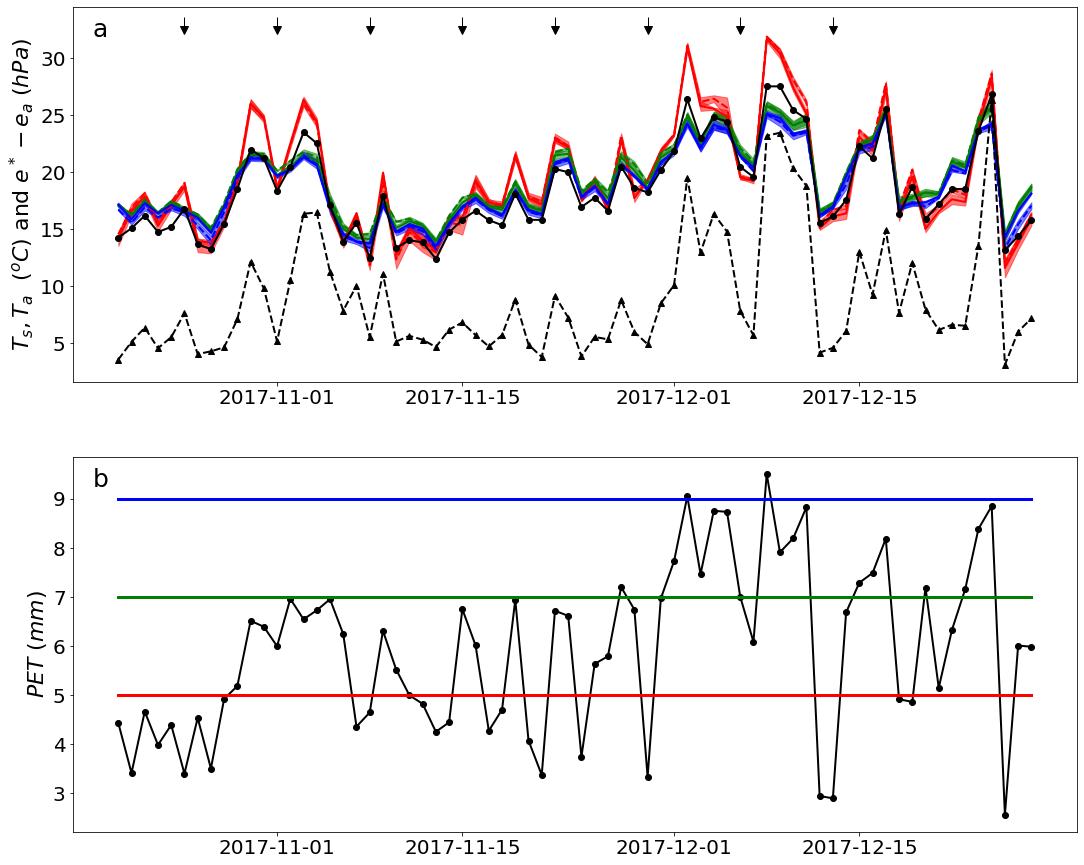

In [37]:
IrrDates = pd.to_datetime(['2017-10-25','2017-11-01','2017-11-08','2017-11-15','2017-11-22','2017-11-29','2017-12-06','2017-12-13'])
Graph = plt.figure(figsize=(18,40))
pos = 0
Fig = Graph.add_subplot(5,1,1)
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        data = Ts.loc[:,(Zone,Irr)].loc['2017-10-20':'2017-12-28',:]
        up = data.mean(axis=1) + data.std(axis=1)/2
        down = data.mean(axis=1) - data.std(axis=1)/2
        plt.plot(data.index,data.mean(axis=1),lines[pos],color = colors[pos],lw=2,label = lab)
        plt.fill_between(data.index,up,down,alpha=0.5, color=colors[pos])
        pos +=1
plt.plot(Ta.loc['2017-10-20':'2017-12-28',:].mean(axis=1),'-o',color='k',lw=2,label='AirT')
plt.plot(Ed.loc['2017-10-20':'2017-12-28',:].mean(axis=1)*10,'--^',color='k',lw=2,label='AirT')
plt.plot(IrrDates,[33] * len(IrrDates),'|',color='k',ms=15)
plt.plot(IrrDates,[32.5] * len(IrrDates),'v',color='k',ms=8)
plt.tick_params(labelsize=20)
plt.ylabel(r'$T_s, T_a$  $(^oC)$ and $e^*-e_a$ $(hPa)$',fontsize = 22)
IrrDates = pd.to_datetime(['2017-10-25','2017-11-01','2017-11-08','2017-11-15','2017-11-22','2017-11-29','2017-12-06','2017-12-13'])
plt.text(0.02,0.92,'a',transform=Fig.transAxes,fontsize=25)
Fig = Graph.add_subplot(5,1,2)
plt.plot(PET.loc['2017-10-20':'2017-12-28',:].mean(axis=1),'-o',color='k',lw=2,label='AirT')
plt.tick_params(labelsize=20)
plt.ylabel(r'$PET$ $(mm)$',fontsize = 22)
plt.plot(pd.to_datetime(['2017-10-20','2017-12-28']),[5,5],'-',lw=3,color = colors[0])
plt.plot(pd.to_datetime(['2017-10-20','2017-12-28']),[7,7],'-',lw=3,color = colors[2])
plt.plot(pd.to_datetime(['2017-10-20','2017-12-28']),[9,9],'-',lw=3,color = colors[4])
plt.text(0.02,0.92,'b',transform=Fig.transAxes,fontsize=25)
Graph.savefig('K:\\CPDiary\\Data\\BaxtersMVI\\draft papers\\Submission versions\\resub\\RevisedBaxtersIrrigPaper\\Figure4.eps',dpi=400)

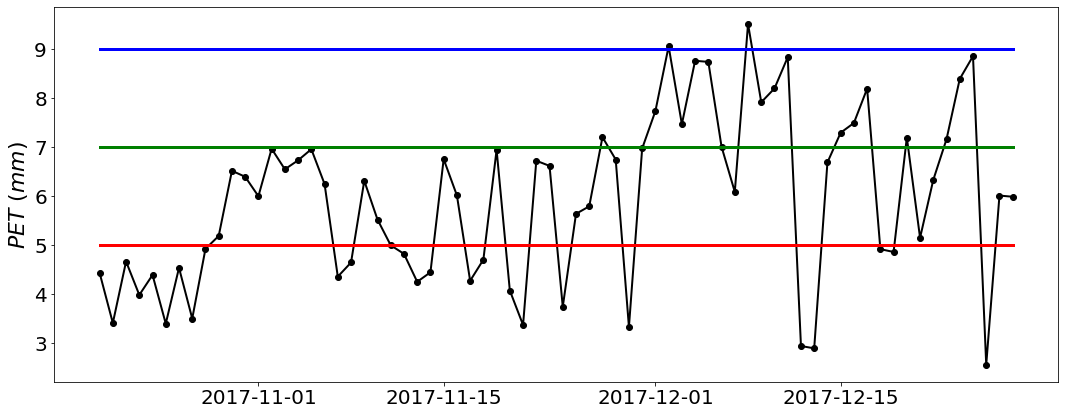

In [38]:
IrrDates = pd.to_datetime(['2017-10-25','2017-11-01','2017-11-08','2017-11-15','2017-11-22','2017-11-29','2017-12-06','2017-12-13'])
Graph = plt.figure(figsize=(18,40))
pos = 0
Fig = Graph.add_subplot(5,1,1)
plt.plot(PET.loc['2017-10-20':'2017-12-28',:].mean(axis=1),'-o',color='k',lw=2,label='AirT')
plt.tick_params(labelsize=20)
plt.ylabel(r'$PET$ $(mm)$',fontsize = 22)
plt.plot(pd.to_datetime(['2017-10-20','2017-12-28']),[5,5],'-',lw=3,color = colors[0])
plt.plot(pd.to_datetime(['2017-10-20','2017-12-28']),[7,7],'-',lw=3,color = colors[2])
plt.plot(pd.to_datetime(['2017-10-20','2017-12-28']),[9,9],'-',lw=3,color = colors[4])

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


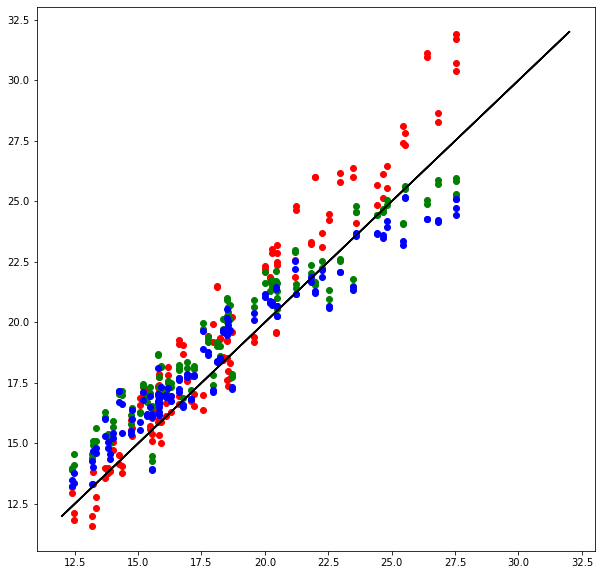

In [39]:
IrrDates = pd.to_datetime(['2017-10-25','2017-11-01','2017-11-08','2017-11-15','2017-11-22','2017-11-29','2017-12-06','2017-12-13'])
Graph = plt.figure(figsize=(10,10))
pos = 0
Fig = Graph.add_subplot(1,1,1)
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        data = Ts.loc[:,(Zone,Irr)].loc['2017-10-20':'2017-12-28',:]
        up = data.mean(axis=1) + data.std(axis=1)/2
        down = data.mean(axis=1) - data.std(axis=1)/2
        plt.plot(Ta.loc['2017-10-20':'2017-12-28',:].mean(axis=1),data.mean(axis=1),'o',color = colors[pos],lw=2,label = lab)
        plt.plot([12,32],[12,32],'-',color='k')
        pos +=1

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


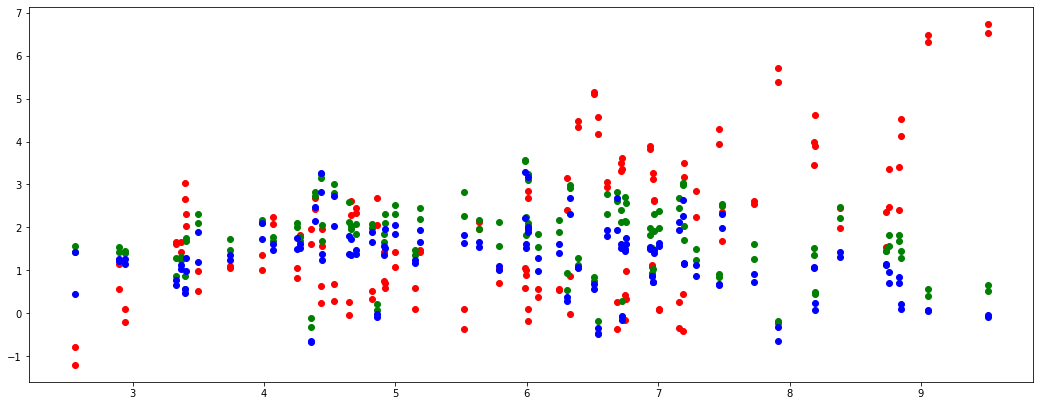

In [40]:
IrrDates = pd.to_datetime(['2017-10-25','2017-11-01','2017-11-08','2017-11-15','2017-11-22','2017-11-29','2017-12-06','2017-12-13'])
Graph = plt.figure(figsize=(18,40))
pos = 0
Fig = Graph.add_subplot(5,1,1)
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        data = Td.loc[:,(Zone,Irr)].loc['2017-10-20':'2017-12-28',:]
        up = data.mean(axis=1) + data.std(axis=1)/2
        down = data.mean(axis=1) - data.std(axis=1)/2
        plt.plot(PET.loc['2017-10-20':'2017-12-28',:].mean(axis=1),data.mean(axis=1),'o',color = colors[pos],lw=2,label = lab)
        #plt.fill_between(data.index,up,down,alpha=0.5, color=colors[pos])
        pos +=1

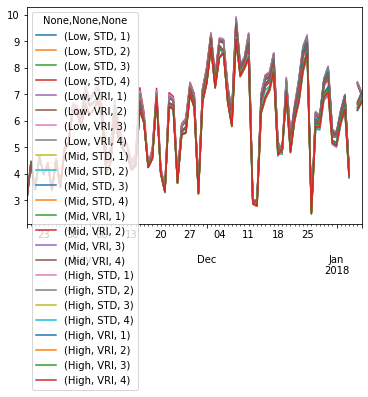

In [41]:
PET.plot()

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


Text(0, 0.5, '$T_s$  $(^oC)$')

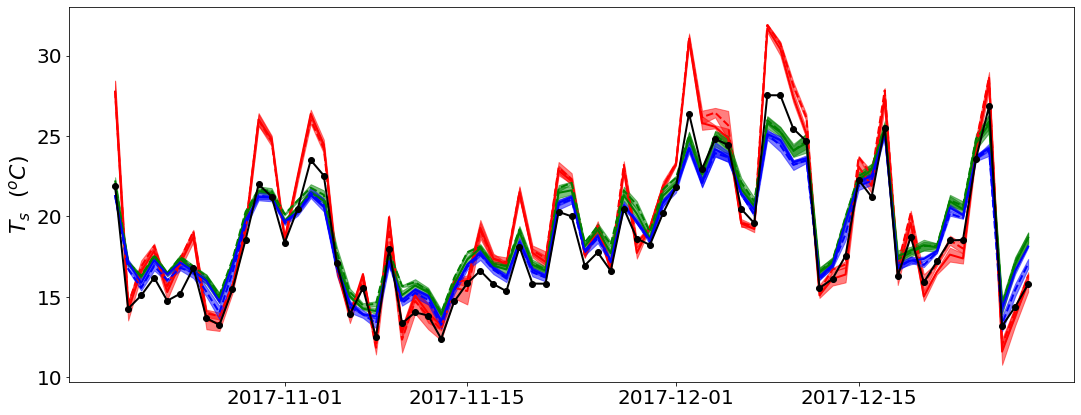

In [42]:
Graph = plt.figure(figsize=(18,40))
pos = 0
Fig = Graph.add_subplot(5,1,1)
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        data = Ts.loc[:,(Zone,Irr)].loc['2017-10-18':'2017-12-28',:]
        up = data.mean(axis=1) + data.std(axis=1)/2
        down = data.mean(axis=1) - data.std(axis=1)/2
        plt.plot(data.index,data.mean(axis=1),lines[pos],color = colors[pos],lw=2,label = lab)
        plt.fill_between(data.index,up,down,alpha=0.5, color=colors[pos])
        pos +=1
plt.plot(Ta.loc['2017-10-18':'2017-12-28',:].mean(axis=1),'-o',color='k',lw=2,label='AirT')
plt.tick_params(labelsize=20)
plt.ylabel(r'$T_s$  $(^oC)$',fontsize = 22)

##  Remove data from plots where sensors are planying up

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


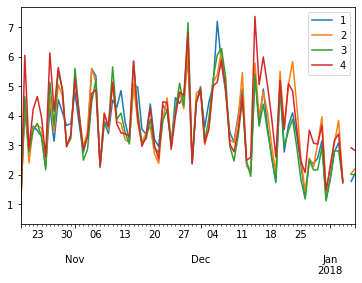

In [43]:
E.loc[:,('Low','VRI')].plot()

In [44]:
E.loc[:,('High','STD',1.0)] = np.nan
E.loc[:,('Low','VRI',4.0)] = np.nan

## Work out how much irrigation is needed
### Enter the date of last irrigation (in yyyy-mm-dd format).  
### The graph is accumulated water use less rainfall from (including) that date up to yesterday

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
The 

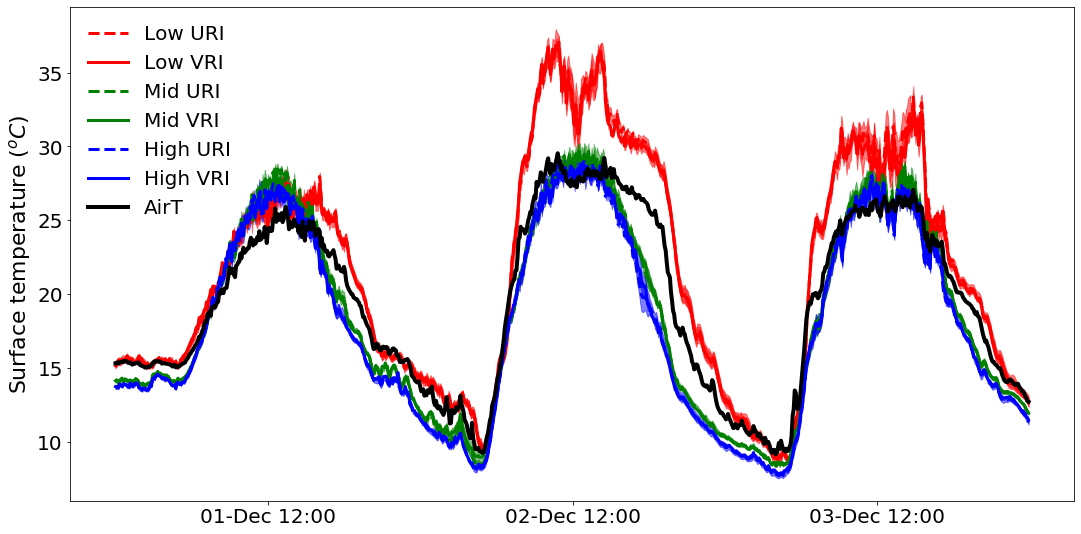

In [57]:
Graph = plt.figure(figsize=(18,20))
pos = 0
Fig = Graph.add_subplot(2,1,1)
IrrLabs = ['URI', 'VRI','URI', 'VRI','URI', 'VRI']
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + IrrLabs[pos]
        data = SurfaceTemp.loc['2017-12-01':'2017-12-03',(Zone,Irr)]
        #plt.plot(data,lines[pos],color = colors[pos],lw=0.5,label = '_nolegend_')
        up = data.mean(axis=1) + data.std(axis=1)/2
        down = data.mean(axis=1) - data.std(axis=1)/2
        plt.plot(data.index,data.mean(axis=1),lines[pos],color = colors[pos],lw=3,label = lab)
        plt.fill_between(data.index,up,down,alpha=0.5, color=colors[pos])
        pos +=1
plt.plot(MidMetData.loc['2017-12-01':'2017-12-03','AirTemp'],color='k',lw=4,label='AirT')
Fig.legend(loc=2,fontsize=20,frameon=False)
#plt.title('SurfaceTemperature',fontsize=28)
plt.tick_params(labelsize=20)
plt.ylabel(r'Surface temperature $(^oC)$',fontsize = 22)
Fig.xaxis.set_major_locator(mdates.HourLocator(12))
Fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b %H:%M'))
Graph.savefig('K:\\CPDiary\\Data\\BaxtersMVI\\draft papers\\Submission versions\\resub\RevisedBaxtersIrrigPaper\\Figure3.eps',dpi=400)

In [ ]:
Start = '2017-11-27'
End = '2017-12-06'
Graph = plt.figure(figsize=(18,30))
pos = 0
ax = Graph.add_subplot(4,1,1)
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        data = SurfaceTemp.loc[Start:End,(Zone,Irr)]
        #plt.plot(data,lines[pos],color = colors[pos],lw=0.5,label = '_nolegend_')
        up = data.mean(axis=1) + data.std(axis=1)/2
        down = data.mean(axis=1) - data.std(axis=1)/2
        plt.plot(data.index,data.mean(axis=1),lines[pos],color = colors[pos],lw=3,label = lab)
        plt.fill_between(data.index,up,down,alpha=0.5, color=colors[pos])
        pos +=1
plt.plot(MidMetData.loc[Start:End,'AirTemp'],color='k',lw=4,label='AirT')
plt.tick_params(labelsize=20)
plt.ylabel('Surface temperature (oC)',fontsize = 22)
ax.xaxis.set_major_locator(mdates.HourLocator(12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

pos = 0
ax = Graph.add_subplot(4,1,2)
for Zone in Zones:
    Ed = MetData.loc[Zone,'Ed'].loc[Start:End]
    plt.plot(Ed.index,Ed,lines[pos],color = colors[pos],lw=3,label = lab)
    pos +=2
plt.tick_params(labelsize=20)
plt.ylabel('VPD (kPa)',fontsize = 22)
ax.xaxis.set_major_locator(mdates.HourLocator(12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

pos = 0
ax = Graph.add_subplot(4,1,3)
for Zone in Zones:
    u = MetData.loc[Zone,'u'].loc[Start:End]
    plt.plot(u.index,u,lines[pos],color = colors[pos],lw=3,label = lab)
    pos +=2
plt.tick_params(labelsize=20)
plt.ylabel('Wind speed (m/s)',fontsize = 22)
ax.xaxis.set_major_locator(mdates.HourLocator(12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

pos = 0
ax = Graph.add_subplot(4,1,4)
for Zone in Zones:
    Ta = MetData.loc[Zone,'Ta'].loc[Start:End]
    plt.plot(Ta.index,Ta,lines[pos],color = colors[pos],lw=3,label = lab)
    pos +=2
plt.tick_params(labelsize=20)
plt.ylabel('Air Temperature (oC)',fontsize = 22)
ax.xaxis.set_major_locator(mdates.HourLocator(12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

In [ ]:
Start = '2017-11-27'
End = '2017-12-06'
Graph = plt.figure(figsize=(18,12))
pos = 0
ax = Graph.add_subplot(1,1,1)
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        data = SurfaceTemp.loc[Start:End,(Zone,Irr)]
        #plt.plot(data,lines[pos],color = colors[pos],lw=0.5,label = '_nolegend_')
        up = data.mean(axis=1) + data.std(axis=1)/2
        down = data.mean(axis=1) - data.std(axis=1)/2
        plt.plot(data.index,data.mean(axis=1),lines[pos],color = colors[pos],lw=3,label = lab)
        plt.fill_between(data.index,up,down,alpha=0.5, color=colors[pos])
        pos +=1
plt.plot(MidMetData.loc[Start:End,'AirTemp'],color='k',lw=4,label='AirT')
plt.tick_params(labelsize=20)
plt.ylabel('Surface temperature (oC)',fontsize = 22)
ax.xaxis.set_major_locator(mdates.HourLocator(12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))


In [ ]:
plt.plot(MetData.loc['High','Ta'],MetData.loc['Mid','Ta'],'o')

In [ ]:
E.to_pickle('Evaporation.pkl')

In [ ]:
DayLightTemps = SurfaceTemp.loc[Daylight,:].dropna()

In [ ]:
SampleDates = pd.date_range(datetime.date(2017,10,19), periods=80).tolist()

In [ ]:
DayTimeMean = DayLightTemps.resample('d').mean().loc[SampleDates].unstack()

In [ ]:
TempSamples = pd.DataFrame(DayTimeMean,columns = ['DayTimeMean'],
                          )

In [ ]:
for h in [7,8,9,10,11,12,13,14,15,16,17,18]:
    for m in [0,30]:
        TimeFilter = (DayLightTemps.index.minute==m) & (DayLightTemps.index.hour==h)
        lab = str(h) + ':' + str(m)
        DownSampledData = DayLightTemps.loc[TimeFilter]
        DownSampledDataDateIndex = DownSampledData.index.date
        DownSampledData.index = DownSampledDataDateIndex
        TempSamples.loc[:,lab] = DownSampledData.loc[SampleDates].unstack()
        

In [ ]:
def MakeLabel(RegStats):
    #text = RegStats.Name + '  n = ' + str(RegStats.n)
    #text = '\ny = ' + '%.2f'%RegStats.Intercept + '(se ' + '%.2f'%RegStats.SEintercept + ') + ' + '%.2f'%RegStats.Slope + '(se ' + '%.2f'%RegStats.SEslope + ') x' 
    text = '\n$r^2$ =' + '%.2f'%RegStats.R2 + ' RMSE = ' + '%.2f'%RegStats.RMSE +' NSE = ' + '%.2f'%RegStats.NSE
    text += '\nME = ' + '%.2f'%RegStats.ME + ' MAE = ' + '%.2f'%RegStats.MAE
    text += '\ny = ' + '%.2f'%RegStats.Intercept + '(se ' + '%.2f'%RegStats.SEintercept + ') + ' + '%.2f'%RegStats.Slope + '(se ' + '%.2f'%RegStats.SEslope + ') x' 
    #text += '\nn = ' + str(RegStats.n)
    return text

In [ ]:
fig = plt.figure(figsize = (12,24))
pos = 1
for s in TempSamples.columns[1:]:
    ax = fig.add_subplot(12,2,pos)
    Pred = TempSamples.loc[:,s]
    Obs = TempSamples.loc[:,'DayTimeMean']
    plt.plot([0,35],[0,35],'-',color='k')
    plt.text(0.05,0.9,'time = ' + s,transform=ax.transAxes)
    RegStats = MUte.MathUtilities.CalcRegressionStats(s,Pred,Obs)
    LabelText = MakeLabel(RegStats)
    plt.text(0.5,.05,LabelText,transform=ax.transAxes)
    plt.ylim(5,35)
    plt.xlim(5,35)
    cpos = 0
    for z in Zones:
        for i in Irrigs:
            plt.plot(TempSamples.loc[(z,i),'DayTimeMean'],
                     TempSamples.loc[(z,i),s], 'o',
                     mec = colors[cpos], mfc = fillcolors[cpos])
            cpos+=1
    
    if pos in [1,3,5,7,9,11,13,15,17,19,21,23]:
        plt.ylabel('$T_s at time (^oC)$')
    if pos in [23,24]:
        plt.xlabel('$Day time T_s (^oC)$')
    pos +=1
fig.savefig('SampleTimes')

In [ ]:
TempSamples.loc[('Low','STD',slice(None),Dates[100]),'DayTimeMean'].mean()

In [ ]:
TempSamples.loc[('Low','STD',slice(None),Dates[100]),:].iloc[:,1:].mean()-11

In [ ]:
Dates  = TempSamples.index.get_level_values(3)

In [ ]:
Graph = plt.figure(figsize=(10,10))
pos=1
for z in Zones:
    ax = Graph.add_subplot(3,1,pos)
    for i in Irrigs:
        for d in Dates:
            res = TempSamples.loc[(z,i,slice(None),d),:].iloc[:,1:].mean() - TempSamples.loc[(z,i,slice(None),d),'DayTimeMean'].mean()
            plt.plot(range(24),res,'o')
    plt.ylim(11,-11)
    pos +=1